# Laboratorium Nr 3
Zadaniem dla zespołów jest przeprowadzenie analizy danych i próba odpowiedzi na pytanie:„Czy na podstawie danych z ostatnich 24 lat można wyciągnąć wnioski na temat ocieplenia klimatu?”

In [3]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from dotenv import load_dotenv
import pyodbc
from sqlalchemy import create_engine, text
from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose

## Przygotowanie danych

In [4]:
load_dotenv()

True

In [5]:

login = os.getenv("LOGIN")
password = os.getenv("PASSWORD")
db_host = os.getenv("DB_HOST")
port = os.getenv("PORT")
database = os.getenv("DB_NAME")

In [ ]:
conn_str = (
    f"mssql+pyodbc://{login}:{password}@{db_host},{port}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
)

In [7]:
engine = create_engine(conn_str)

In [8]:
query_depesze = text("""
        SELECT idstacji, Data, TemperaturaPowietrza, WysokoscOpadu, CisnienieNaPoziomieStacji, CzySnieg, CzyZamiec
        FROM Synop.dbo.Depesze as depesze
        WHERE depesze.Data BETWEEN '2000-01-01' and '2025-01-01'
    """)



In [9]:
query_stacje = text("""
        SELECT IDStacji, Nazwa, Wojewodztwo, Szerokosc, Dlugosc, Wysokosc
        FROM  Synop.dbo.Stacje as stacje
        WHERE stacje.Kraj = 'Poland'
    """)


In [10]:

""" 
with engine.connect() as conn:
    df_depesze = pd.read_sql(query_depesze, conn)
"""

' \nwith engine.connect() as conn:\n    df_depesze = pd.read_sql(query_depesze, conn)\n'

In [11]:
#df_depesze.to_csv('depesze_output.csv', encoding='utf-8')

In [12]:
df_depesze = pd.read_csv('depesze_output.csv')

In [13]:

with engine.connect() as conn:
    df_stacje = pd.read_sql(query_stacje, conn)

In [14]:
df_merged = df_depesze.merge(df_stacje, left_on="idstacji", right_on="IDStacji", how="left")

In [15]:
df_merged = df_merged.drop(columns=["IDStacji", "idstacji"])

In [16]:
df_merged.head(5)


,Unnamed: 0,Data,TemperaturaPowietrza,WysokoscOpadu,CisnienieNaPoziomieStacji,CzySnieg,CzyZamiec,Nazwa,Wojewodztwo,Szerokosc,Dlugosc,Wysokosc
0,0,2000-04-13,7.7,0.0,980.2,False,False,Łódź,łódzkie,51.727400,19.403068,187.0
1,1,2000-04-13,8.0,0.0,980.5,False,False,Sulejów,łódzkie,51.354039,19.876077,188.0
2,2,2000-04-13,9.8,0.0,988.1,False,False,Kozienice,mazowieckie,51.564827,21.542642,107.0
3,3,2000-04-13,10.1,0.0,974.9,False,False,Lublin,lubelskie,51.218023,22.395899,238.0
4,4,2000-04-13,11.8,0.0,982.1,False,False,Włodawa,lubelskie,51.550971,23.536622,177.0


In [17]:
df_merged.describe()

,Unnamed: 0,TemperaturaPowietrza,WysokoscOpadu,CisnienieNaPoziomieStacji,Wysokosc
count,1.270889e+07,1.270878e+07,1.270889e+07,1.270889e+07,1.270889e+07
mean,6.354446e+06,8.940766e+00,1.278610e-01,9.067828e+02,1.975001e+02
std,3.668742e+06,8.813644e+00,2.387944e+00,2.778723e+02,3.040370e+02
min,0.000000e+00,-9.820000e+01,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.177223e+06,2.300000e+00,0.000000e+00,9.818000e+02,7.200000e+01
50%,6.354446e+06,8.700000e+00,0.000000e+00,9.955000e+02,1.330000e+02
75%,9.531670e+06,1.550000e+01,0.000000e+00,1.005900e+03,2.050000e+02
max,1.270889e+07,9.600000e+01,9.880000e+02,1.099900e+03,1.991000e+03


## Czyścimy dane

In [18]:
df = df_merged.copy()
df["Data"] = pd.to_datetime(df["Data"])
df["Rok"] = df["Data"].dt.year
df["Miesiąc"] = df["Data"].dt.month

In [19]:
df = df[df["TemperaturaPowietrza"].notnull()]

In [20]:
# Liczba wierszy z brakującymi danymi  w każdej kolumnie
df.isnull().sum()


Unnamed: 0                   0
Data                         0
TemperaturaPowietrza         0
WysokoscOpadu                0
CisnienieNaPoziomieStacji    0
CzySnieg                     0
CzyZamiec                    0
Nazwa                        2
Wojewodztwo                  2
Szerokosc                    2
Dlugosc                      2
Wysokosc                     2
Rok                          0
Miesiąc                      0
dtype: int64

In [21]:

print(df['TemperaturaPowietrza'].max())

96.0


In [22]:
print(df['TemperaturaPowietrza'].min())

-98.2


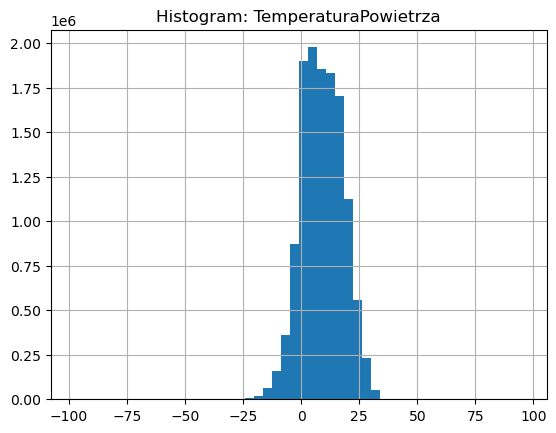

In [23]:
#  Wykres do wykrywania outlierów

df["TemperaturaPowietrza"].hist(bins=50)
plt.title("Histogram: TemperaturaPowietrza")
plt.show()


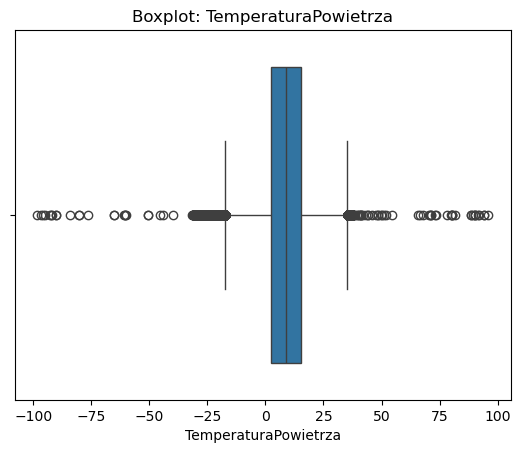

In [24]:
sns.boxplot(x=df["TemperaturaPowietrza"])
plt.title("Boxplot: TemperaturaPowietrza")
plt.show()

In [25]:
Q1 = df["TemperaturaPowietrza"].quantile(0.25)
Q3 = df["TemperaturaPowietrza"].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[
    (df["TemperaturaPowietrza"] >= Q1 - 1.5 * IQR) &
    (df["TemperaturaPowietrza"] <= Q3 + 1.5 * IQR)
]

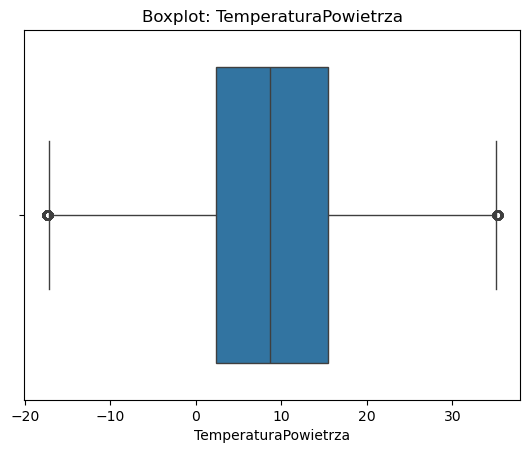

In [26]:
sns.boxplot(x=df_no_outliers["TemperaturaPowietrza"])
plt.title("Boxplot: TemperaturaPowietrza")
plt.show()

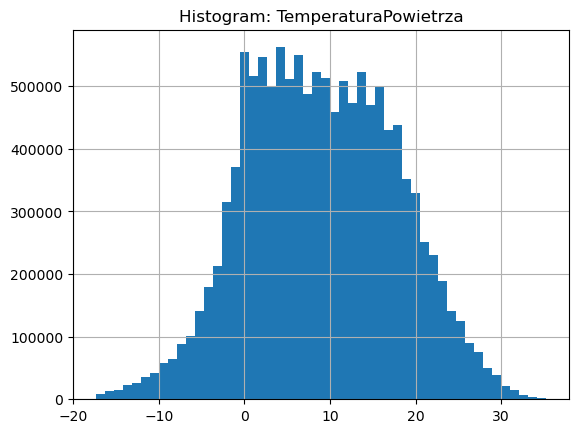

In [27]:
df_no_outliers["TemperaturaPowietrza"].hist(bins=50)
plt.title("Histogram: TemperaturaPowietrza")
plt.show()

In [28]:
df = df_no_outliers.copy()

In [29]:
df['Wojewodztwo'].unique()

array(['łódzkie', 'mazowieckie', 'lubelskie', 'dolnośląskie', 'opolskie',
       'śląskie', 'małopolskie', 'świętokrzyskie', 'podkarpackie',
       'zachodniopomorskie', 'pomorskie', 'warmińsko-mazurskie',
       'podlaskie', 'wielkopolskie', 'kujawsko-pomorskie', 'lubuskie', '',
       nan], dtype=object)

In [30]:
df = df[df['Wojewodztwo'].notnull()]

In [31]:
df = df[df['Wojewodztwo'] != '']

In [32]:
df['Wojewodztwo'].unique()

array(['łódzkie', 'mazowieckie', 'lubelskie', 'dolnośląskie', 'opolskie',
       'śląskie', 'małopolskie', 'świętokrzyskie', 'podkarpackie',
       'zachodniopomorskie', 'pomorskie', 'warmińsko-mazurskie',
       'podlaskie', 'wielkopolskie', 'kujawsko-pomorskie', 'lubuskie'],
      dtype=object)

### Dodatkowe kolumny

In [33]:
df["Data"] = pd.to_datetime(df["Data"])
df["Rok"] = df["Data"].dt.year
df["Miesiąc"] = df["Data"].dt.month

In [34]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Zima"
    elif month in [3, 4, 5]:
        return "Wiosna"
    elif month in [6, 7, 8]:
        return "Lato"
    else:
        return "Jesień"

df["Sezon"] = df["Miesiąc"].apply(get_season)

In [35]:
df.head(5)

,Unnamed: 0,Data,TemperaturaPowietrza,WysokoscOpadu,CisnienieNaPoziomieStacji,CzySnieg,CzyZamiec,Nazwa,Wojewodztwo,Szerokosc,Dlugosc,Wysokosc,Rok,Miesiąc,Sezon
0,0,2000-04-13,7.7,0.0,980.2,False,False,Łódź,łódzkie,51.727400,19.403068,187.0,2000,4,Wiosna
1,1,2000-04-13,8.0,0.0,980.5,False,False,Sulejów,łódzkie,51.354039,19.876077,188.0,2000,4,Wiosna
2,2,2000-04-13,9.8,0.0,988.1,False,False,Kozienice,mazowieckie,51.564827,21.542642,107.0,2000,4,Wiosna
3,3,2000-04-13,10.1,0.0,974.9,False,False,Lublin,lubelskie,51.218023,22.395899,238.0,2000,4,Wiosna
4,4,2000-04-13,11.8,0.0,982.1,False,False,Włodawa,lubelskie,51.550971,23.536622,177.0,2000,4,Wiosna


In [36]:
df.columns

Index(['Unnamed: 0', 'Data', 'TemperaturaPowietrza', 'WysokoscOpadu',
       'CisnienieNaPoziomieStacji', 'CzySnieg', 'CzyZamiec', 'Nazwa',
       'Wojewodztwo', 'Szerokosc', 'Dlugosc', 'Wysokosc', 'Rok', 'Miesiąc',
       'Sezon'],
      dtype='object')

In [37]:
df["TemperaturaPowietrza"] = df["TemperaturaPowietrza"].interpolate(method="linear")

### Agregacja

In [38]:
monthly_by_region = (
    df.groupby(["Rok","Miesiąc","Sezon"])["TemperaturaPowietrza"]
    .mean()
    .reset_index()
)


In [39]:
monthly_by_region.head(5)

,Rok,Miesiąc,Sezon,TemperaturaPowietrza
0,2000,1,Zima,-1.426876
1,2000,2,Zima,2.165239
2,2000,3,Wiosna,3.273093
3,2000,4,Wiosna,11.410809
4,2000,5,Wiosna,14.462008


## Wizualizacja

In [40]:

monthly_avg = (
    df.groupby(["Rok", "Miesiąc"])["TemperaturaPowietrza"]
    .mean()
    .reset_index()
)

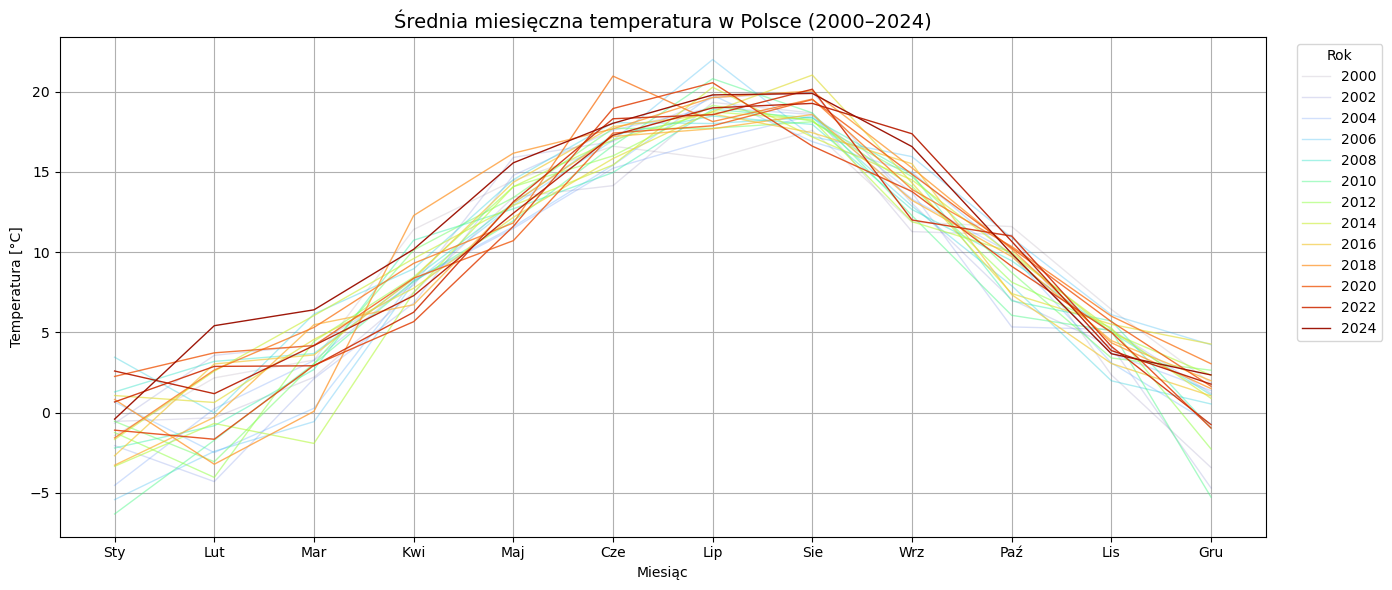

In [41]:
years_sorted = sorted(monthly_avg["Rok"].unique())
n_years = len(years_sorted)
cmap = plt.cm.turbo 

plt.figure(figsize=(14, 6))

for idx, year in enumerate(years_sorted):
    alpha = 0.1 + 0.9 * (idx / (n_years - 1))  # starsze: alpha~0.1, nowsze: ~1
    color = cmap(idx / (n_years - 1))         # kolor zgodnie z wiekiem
    data = monthly_avg[monthly_avg["Rok"] == year]
    
    plt.plot(
        data["Miesiąc"],
        data["TemperaturaPowietrza"],
        label=str(year),
        color=color,
        alpha=alpha,
        linewidth=2 if year >= years_sorted[-1] else 1
    )

# Oś X z nazwami miesięcy
plt.xticks(ticks=range(1, 13), labels=[
    "Sty", "Lut", "Mar", "Kwi", "Maj", "Cze", 
    "Lip", "Sie", "Wrz", "Paź", "Lis", "Gru"
])

plt.title("Średnia miesięczna temperatura w Polsce (2000–2024)", fontsize=14)
plt.xlabel("Miesiąc")
plt.ylabel("Temperatura [°C]")
plt.grid(True)

# Legenda tylko co kilka lat (żeby nie zagracać)
skip = max(n_years // 10, 1)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[::skip], labels[::skip], 
    title="Rok", bbox_to_anchor=(1.02, 1), loc="upper left"
)

plt.tight_layout()
plt.show()



## Dodajemy geodane

Analiza trendu dla poszczególnych województw - regresja liniowa. Analizujemy, jak zmieniała się średnia roczna temperatura co 5 lat.

In [42]:
gdf_woj = gpd.read_file("polska_wojewodztwa.geojson")
gdf_woj["Wojewodztwo"] = gdf_woj["name"].str.lower()

In [43]:
def calculate_trends(df):
    results = []
    for woj, group in df.groupby("Wojewodztwo"):
        if group["Rok"].nunique() < 3:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(group["Rok"], group["TemperaturaPowietrza"])
        results.append({
            "Wojewodztwo": woj,
            "Trend": round(slope, 3),
            "intercept": round(intercept, 3),
            "r_value": round(r_value, 3),
            "p_value": round(p_value, 3),
            "std_err": round(std_err, 3),
        })
    return pd.DataFrame(results)


In [44]:
df_trendy = calculate_trends(df)

In [45]:
df_trendy[df_trendy.p_value > 0.05]

,Wojewodztwo,Trend,intercept,r_value,p_value,std_err


In [46]:
gdf_woj = gdf_woj.merge(df_trendy, on="Wojewodztwo", how="left")

In [47]:
gdf_woj.head(5)

,name,geometry,Wojewodztwo,Trend,intercept,r_value,p_value,std_err
0,dolnośląskie,"POLYGON ((15 50.5, 17 50.5, 17 51.5, 15 51.5, ...",dolnośląskie,0.072,-137.301,0.062,0.0,0.001
1,kujawsko-pomorskie,"POLYGON ((18 52.5, 20 52.5, 20 53.5, 18 53.5, ...",kujawsko-pomorskie,0.068,-127.619,0.052,0.0,0.002
2,lubelskie,"POLYGON ((22 50.5, 24 50.5, 24 51.5, 22 51.5, ...",lubelskie,0.073,-137.901,0.059,0.0,0.001
3,lubuskie,"POLYGON ((14.5 51.5, 15.5 51.5, 15.5 52.5, 14....",lubuskie,0.074,-139.385,0.066,0.0,0.001
4,łódzkie,"POLYGON ((19 51, 21 51, 21 52, 19 52, 19 51))",łódzkie,0.048,-86.622,0.036,0.0,0.001


In [48]:
df_stacje = df.drop_duplicates(subset=["Szerokosc", "Dlugosc"]).copy()

gdf_stacje = gpd.GeoDataFrame(
    df_stacje,
    geometry=gpd.points_from_xy(df_stacje["Dlugosc"], df_stacje["Szerokosc"]),
    crs="EPSG:4326"
)


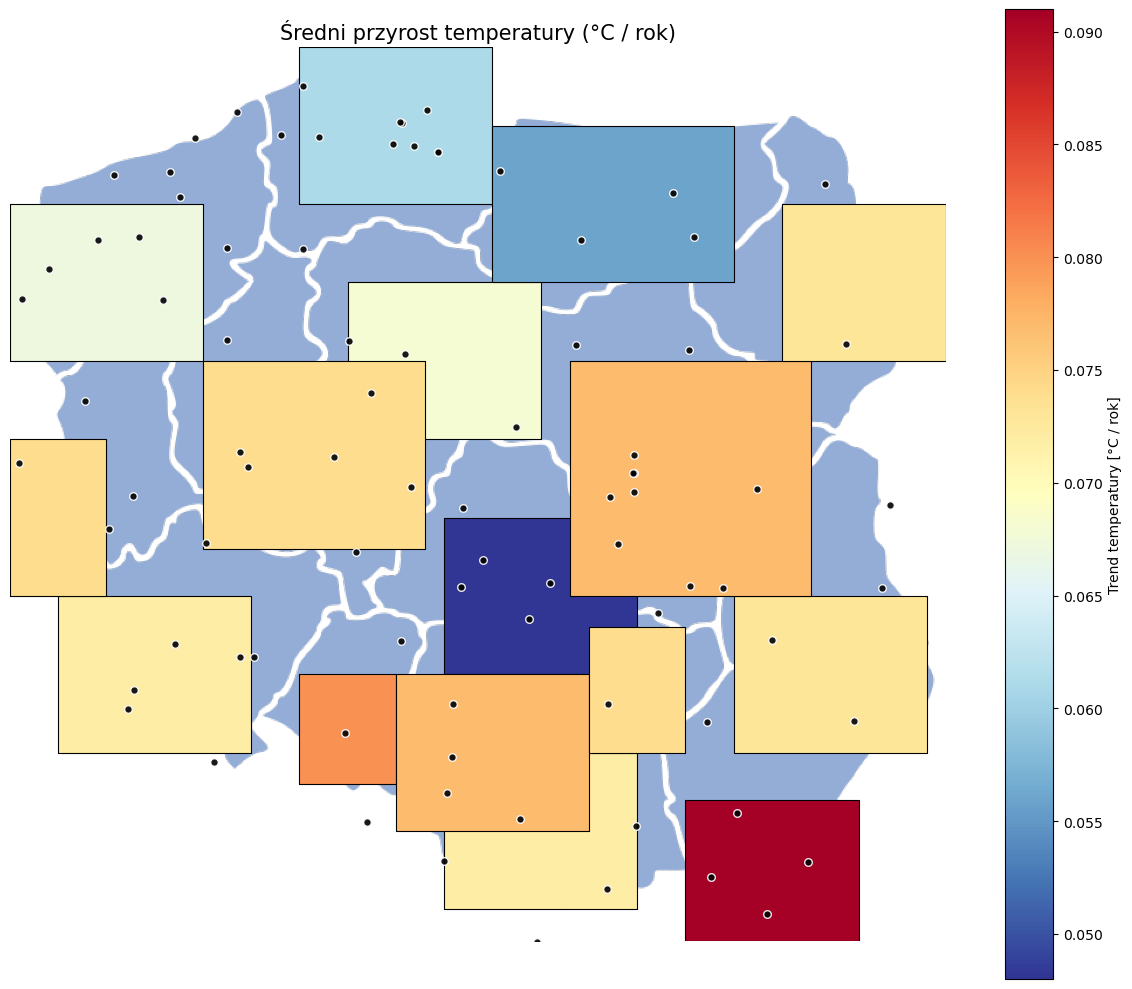

In [49]:

xmin, ymin, xmax, ymax = gdf_woj.total_bounds  

fig, ax = plt.subplots(figsize=(12, 10))

img = mpimg.imread("map.png")
ax.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=0)

gdf_woj.plot(
    ax=ax,
    column="Trend",
    cmap="RdYlBu_r",
    edgecolor="black",
    linewidth=0.8,
    legend=True,
    legend_kwds={'label': "Trend temperatury [°C / rok]"},
    zorder=2  
)

gdf_stacje.plot(
    ax=ax,
    color="black",
    markersize=30,
    alpha=0.9,
    edgecolor="white",
    zorder=3  
)


ax.set_title("Średni przyrost temperatury (°C / rok)", fontsize=15)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.axis("off")
plt.tight_layout()
plt.show()


## Analiza trendu

In [50]:
def calculate_seasonal_trends(df):
    results = []
    grouped = df.groupby(["Wojewodztwo", "Sezon"])
    
    for (woj, sezon), group in grouped:
        if group["Rok"].nunique() < 3:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(group["Rok"], group["TemperaturaPowietrza"])
        results.append({
            "Wojewodztwo": woj,
            "Sezon": sezon,
            "Trend": round(slope, 3),
            "intercept": round(intercept, 3),
            "r_value": round(r_value, 3),
            "p_value": round(p_value, 3),
            "std_err": round(std_err, 3)
        })
    
    return pd.DataFrame(results)

df_sezon_trendy = calculate_seasonal_trends(df)


In [51]:
order = (
    df_sezon_trendy.groupby("Wojewodztwo")["Trend"]
    .mean()
    .sort_values(ascending=False)
    .index
)

In [52]:
seasonal_palette = {
    "Wiosna": "#4CAF50",
    "Lato": "#FFC107",
    "Jesień": "#FF5722",
    "Zima": "#03A9F4"
}

In [53]:
df_sezon_trendy[df_sezon_trendy.p_value > 0.05]

,Wojewodztwo,Sezon,Trend,intercept,r_value,p_value,std_err
10,lubelskie,Wiosna,0.004,0.640,0.004,0.058,0.002
22,małopolskie,Wiosna,0.001,4.668,0.001,0.681,0.002
42,warmińsko-mazurskie,Wiosna,0.002,3.607,0.002,0.330,0.002
54,łódzkie,Wiosna,-0.004,17.335,-0.004,0.057,0.002
58,śląskie,Wiosna,0.002,4.838,0.002,0.323,0.002
62,świętokrzyskie,Wiosna,0.005,-2.003,0.006,0.087,0.003


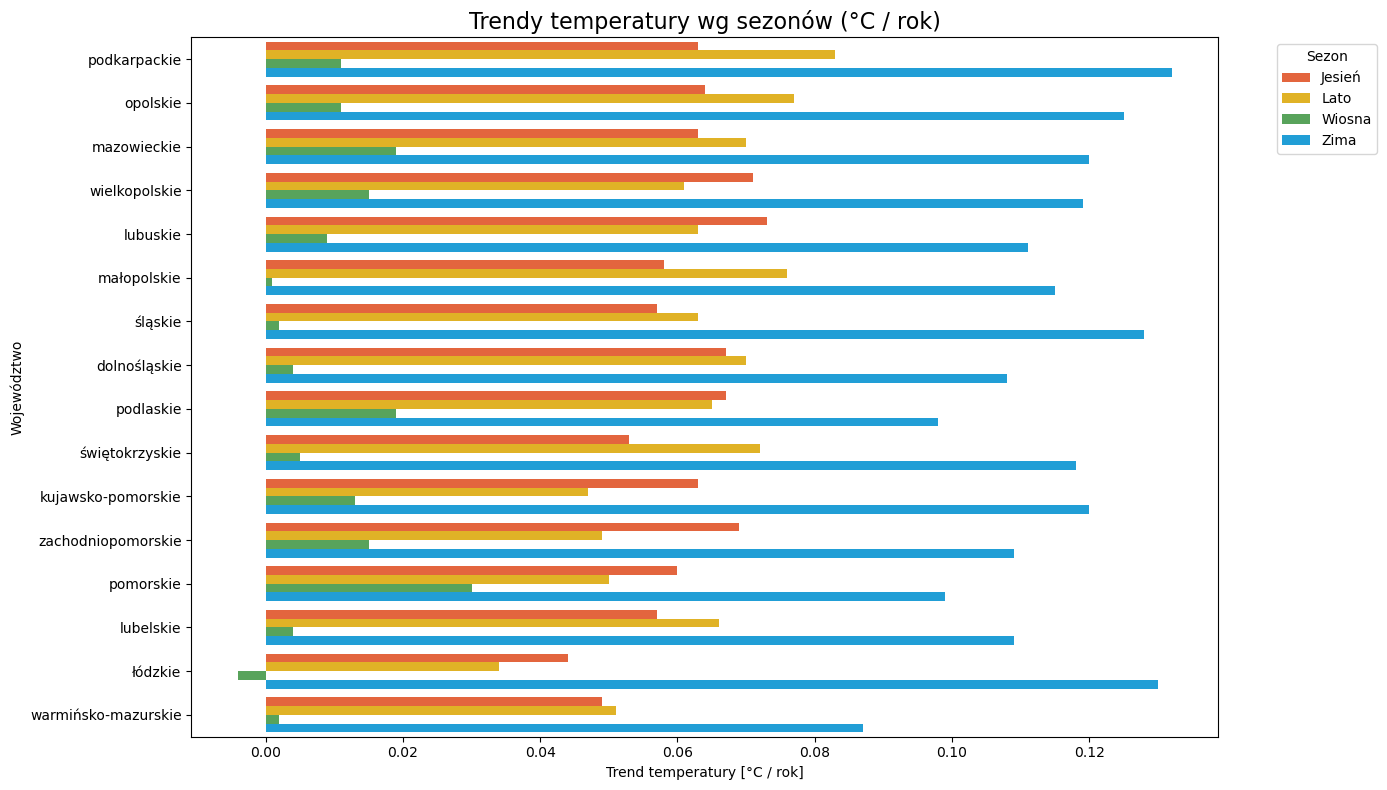

In [54]:

plt.figure(figsize=(14, 8))

sns.barplot(
    data=df_sezon_trendy,
    x="Trend",
    y="Wojewodztwo",
    hue="Sezon",
    order=order,
    palette=seasonal_palette
)

plt.title("Trendy temperatury wg sezonów (°C / rok)", fontsize=16)
plt.xlabel("Trend temperatury [°C / rok]")
plt.ylabel("Województwo")
plt.legend(title="Sezon", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Pogoda w zimie: czy sezony rzeczywsićie powoli "zanikają", a zimy robią się bezśnieżne?

In [55]:
df_zima = df[df["Sezon"] == "Zima"]

In [56]:
df_zima['Snieg_Zamiec'] = df["Snieg_Zamiec"] = df["CzySnieg"] | df["CzyZamiec"]

/tmp/ipykernel_43613/2512500106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zima['Snieg_Zamiec'] = df["Snieg_Zamiec"] = df["CzySnieg"] | df["CzyZamiec"]


In [57]:
df_zima.head(5)

,Unnamed: 0,Data,TemperaturaPowietrza,WysokoscOpadu,CisnienieNaPoziomieStacji,CzySnieg,CzyZamiec,Nazwa,Wojewodztwo,Szerokosc,Dlugosc,Wysokosc,Rok,Miesiąc,Sezon,Snieg_Zamiec
165998,165998,2000-12-01,5.4,0.0,1016.0,False,False,Koszalin,zachodniopomorskie,54.204928,16.156022,32.0,2000,12,Zima,False
165999,165999,2000-12-01,5.9,0.0,1018.1,False,False,Ustka,pomorskie,54.586395,16.854320,6.0,2000,12,Zima,False
166000,166000,2000-12-01,5.6,0.0,1018.5,False,False,Łeba,pomorskie,54.754190,17.532234,2.0,2000,12,Zima,False
166001,166001,2000-12-01,6.6,0.0,1018.8,False,False,Hel,pomorskie,54.602856,18.817706,1.0,2000,12,Zima,False
166002,166002,2000-12-01,8.0,0.0,1018.6,False,False,Gdańsk Port Pn.,pomorskie,54.367853,18.683003,2.0,2000,12,Zima,False


In [58]:
df_days_snow = (
    df.groupby(["Wojewodztwo", "Rok"])["Snieg_Zamiec"]
    .sum() 
    .reset_index()
    .rename(columns={"Snieg_Zamiec": "DaysWithSnow"})
)


In [59]:
trends = []
for woj, group in df_days_snow.groupby("Wojewodztwo"):
    if group["Rok"].nunique() < 3:
        continue
    
    slope, intercept, r_value, p_value, std_err = linregress(group["Rok"], group["DaysWithSnow"])
    
    
    trends.append({
        "Wojewodztwo": woj,
        "TrendDaysPerYear": round(slope, 2),
        "p_value": round(p_value, 4)
    })

df_trends_snow = pd.DataFrame(trends)

In [60]:
df_trends_snow[df_trends_snow.p_value > 0.05]

,Wojewodztwo,TrendDaysPerYear,p_value
0,dolnośląskie,4.30,0.8589
1,kujawsko-pomorskie,-4.12,0.4163
2,lubelskie,11.69,0.4571
3,lubuskie,2.59,0.8376
4,mazowieckie,-2.22,0.9353
5,małopolskie,40.23,0.1384
6,opolskie,-5.25,0.1337
7,podkarpackie,11.53,0.4867
8,podlaskie,5.08,0.6261
9,pomorskie,-1.07,0.9483


/tmp/ipykernel_43613/2193624526.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


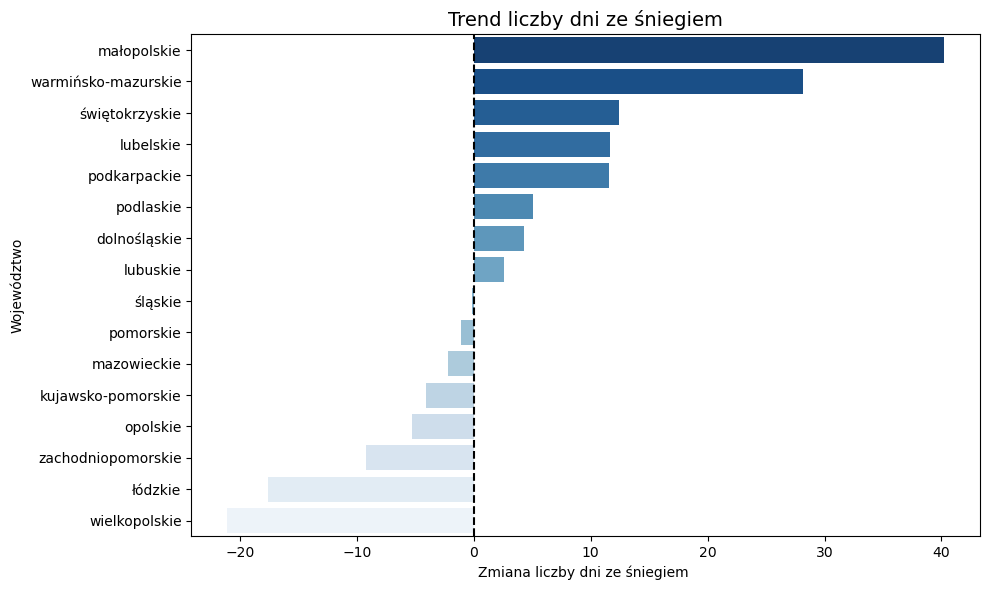

In [61]:


df_trends_snow = df_trends_snow.sort_values("TrendDaysPerYear", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_trends_snow,
    x="TrendDaysPerYear",
    y="Wojewodztwo",
    palette="Blues_r"
)

plt.axvline(0, color="k", linestyle="--")

plt.title("Trend liczby dni ze śniegiem", fontsize=14)
plt.xlabel("Zmiana liczby dni ze śniegiem ")
plt.ylabel("Województwo")
plt.tight_layout()
plt.show()


## Analiza szeregów czasowych

In [62]:
df_szereg = df.groupby("Data")["TemperaturaPowietrza"].mean().reset_index()

In [63]:
df_szereg.set_index("Data", inplace=True)
df_szereg = df_szereg.asfreq("D")

In [64]:
df_szereg

,TemperaturaPowietrza
Data,
2000-01-01,-2.749580
2000-01-02,-2.926064
2000-01-03,1.328427
2000-01-04,2.060965
2000-01-05,2.180645
...,...
2024-12-28,0.932195
2024-12-29,0.668780
2024-12-30,1.166574


In [65]:
df_szereg.head()

,TemperaturaPowietrza
Data,
2000-01-01,-2.749580
2000-01-02,-2.926064
2000-01-03,1.328427
2000-01-04,2.060965
2000-01-05,2.180645


In [66]:
df_szereg["TemperaturaPowietrza"] = df_szereg["TemperaturaPowietrza"].interpolate(method="linear")

In [67]:
decomposition = seasonal_decompose(df_szereg["TemperaturaPowietrza"], model="additive", period=365)

In [68]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


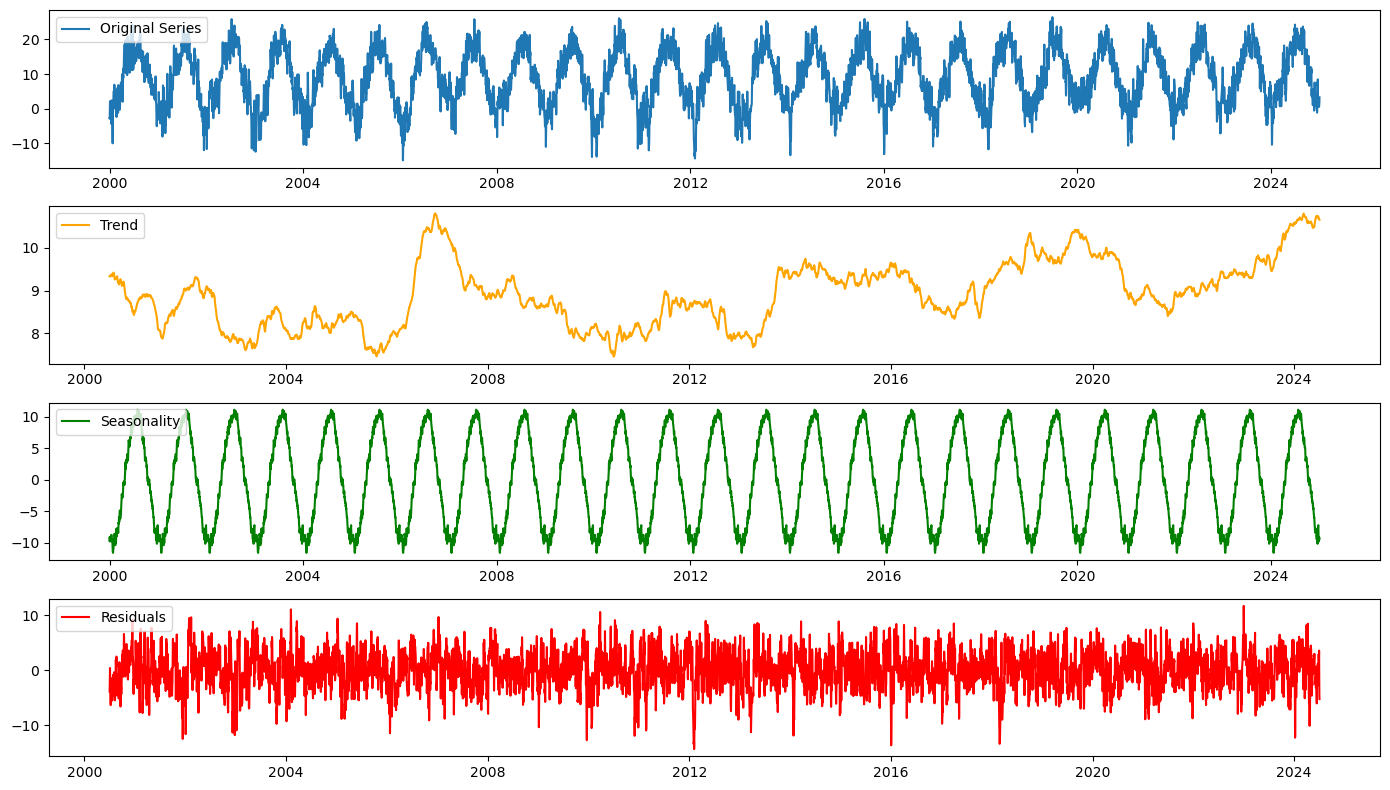

In [69]:

plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(df_szereg["TemperaturaPowietrza"], label="Original Series")
plt.legend(loc="upper left")

plt.subplot(412)
plt.plot(trend, label="Trend", color="orange")
plt.legend(loc="upper left")

plt.subplot(413)
plt.plot(seasonal, label="Seasonality", color="green")
plt.legend(loc="upper left")

plt.subplot(414)
plt.plot(residual, label="Residuals", color="red")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()